In [1]:
import pandas as pd
import geopandas
import itertools
from itertools import chain
from collections import Counter
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rcParams['savefig.dpi'] = 400
matplotlib.rcParams["figure.dpi"] = 300
import json
import numpy as np

In [2]:
mon = pd.read_csv('AIES-2022-lightning-monday.csv')
tues = pd.read_csv('AIES-2022-lightning-tuesday.csv')
student = pd.read_csv('AIES-2022-student-lightning.csv')
keynote = pd.read_csv('AIES-2022-keynote.csv')

In [3]:
mon_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(mon.loc[:,mon.columns[1:]].values.tolist())))
tues_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(tues.loc[:,tues.columns[1:]].values.tolist())))
student_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(student.loc[:,student.columns[1:]].values.tolist())))
keynote_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(keynote.loc[:,keynote.columns[1:]].values.tolist())))

In [4]:
def org_hist(org_list, title_pattern='all'):
    orgs, cnts = zip(*Counter(org_list).most_common())
    plt.figure(figsize=(5, 0.3 * len(orgs)))
    plt.yticks(fontsize=12)
    plt.barh(orgs, cnts)
    plt.title(f'Organisation distribution of {title_pattern} AIES 2022 talks')
    plt.gca().invert_yaxis()

In [5]:
def org_countries(org_list):
    with open('org_country.json', 'r') as f:
        org_country_dict = json.load(f)
    countries = {}
    for country, orgs in org_country_dict.items():
        cnt = 0
        for org in orgs:
            cnt += org_list.count(org)
        if cnt > 0:
            countries[country] = cnt
    if 'Company' in countries.keys():
        del(countries['Company'])
    return countries

In [6]:
def country_pie(org_list, agg_ones=True, one_x=0.7, one_y=-0.2, title_pattern='all'):
    countries = org_countries(org_list)
    countries_sorted, cnts_sorted = zip(*sorted(countries.items(), key=lambda item: item[1], reverse=True))
    print(cnts_sorted)

    def my_autopct(pct, data):
        absolute = int(np.round(pct/100.*np.sum(data)))
        return "{:.1f}% ({:d})".format(pct, absolute) if absolute > 1 or agg_ones==False else ''

    plt.figure(figsize=(10, 10))
    if agg_ones:
        plt.text(one_x, one_y, "{:.1f}% ({:d})".format(100 / sum(cnts_sorted), 1) , fontsize=20)
    plt.title(f'Country distribution of {title_pattern} AIES 2022 talks')
    plt.pie(cnts_sorted, 
            labels=countries_sorted, 
            autopct=lambda pct: my_autopct(pct, cnts_sorted), 
            textprops={'fontsize': 13},
            pctdistance=0.8,
            labeldistance=1.2
    )


In [7]:
all_talks = mon_inst + tues_inst + student_inst + keynote_inst

(47, 23, 12, 10, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)


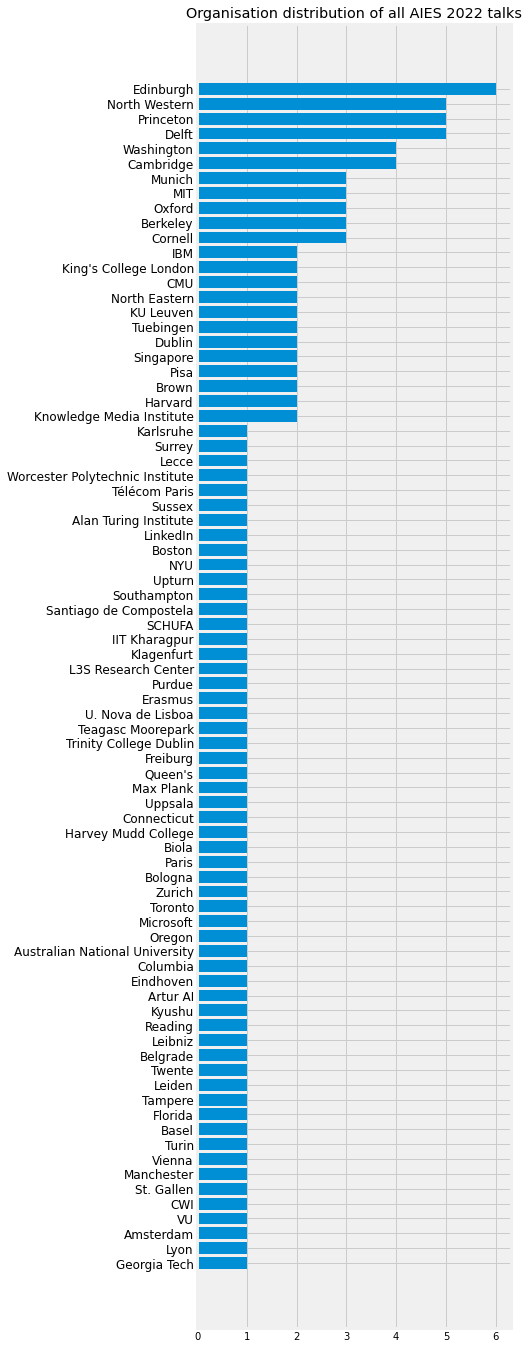

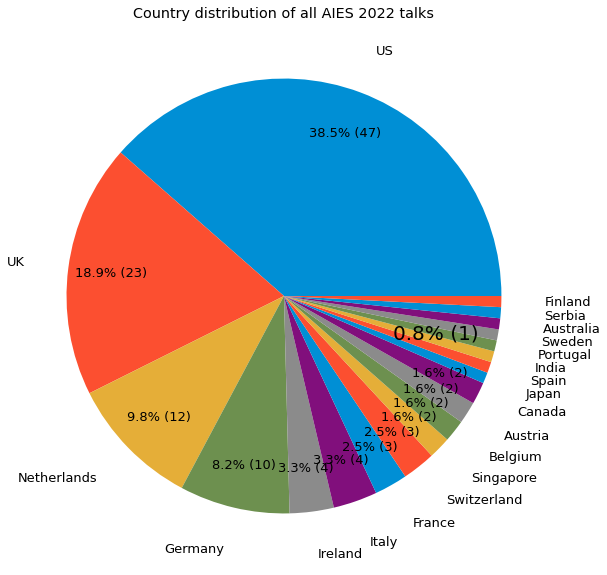

In [8]:
org_hist(all_talks)
plt.savefig("figs/all_orgs.png", bbox_inches='tight')
country_pie(all_talks, one_x=0.5)
plt.savefig("figs/all_countries.png", bbox_inches='tight')

(36, 14, 8, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1)


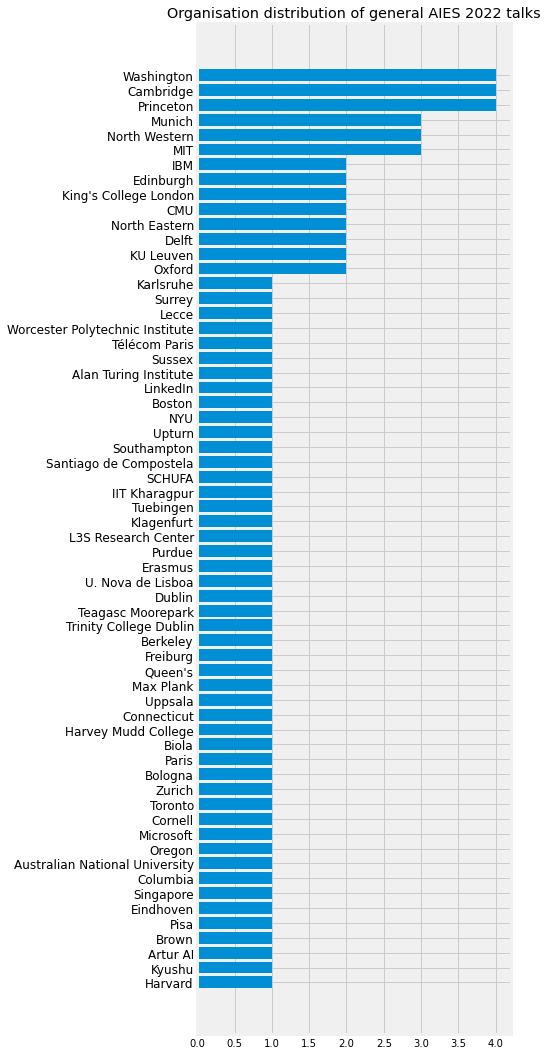

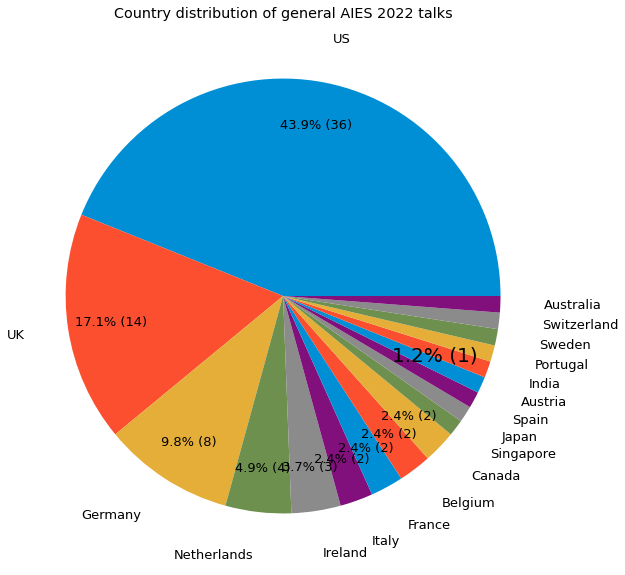

In [9]:
org_hist(mon_inst + tues_inst, title_pattern='general')
plt.savefig("figs/mon-tues_orgs.png", bbox_inches='tight')
country_pie(mon_inst + tues_inst, one_x=0.5 , one_y=-0.3, title_pattern='general')
plt.savefig("figs/mon-tues_countries.png", bbox_inches='tight')

(8, 8, 7, 2, 2, 2, 1, 1, 1, 1, 1, 1)


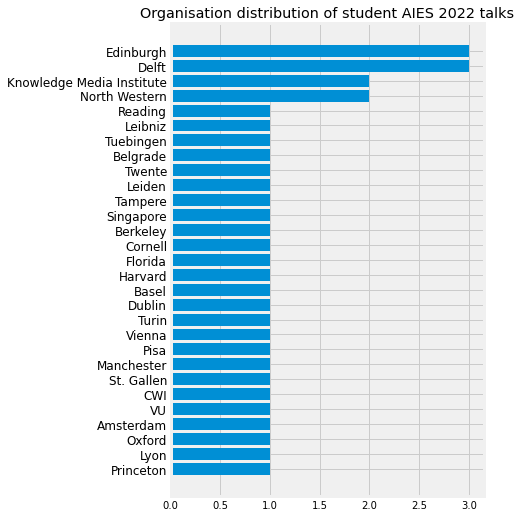

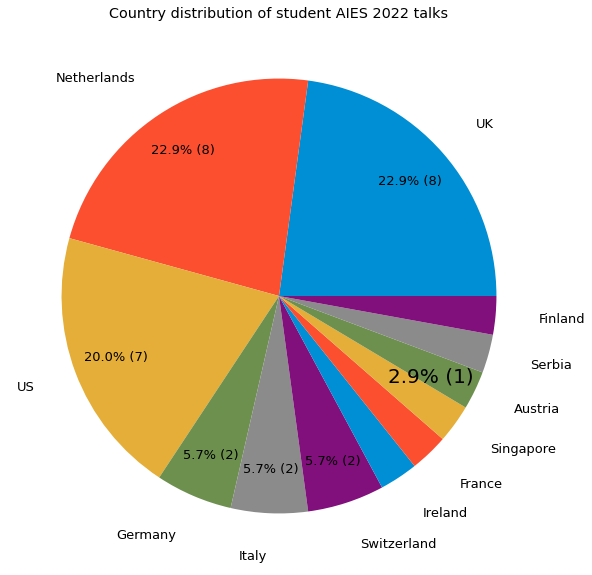

In [10]:
org_hist(student_inst, title_pattern='student')
plt.savefig("figs/student_orgs.png", bbox_inches='tight')
country_pie(student_inst, one_x=0.5, one_y=-0.4, title_pattern='student')
plt.savefig("figs/student_countries.png", bbox_inches='tight')

(4, 1)


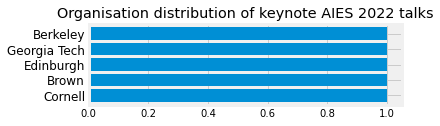

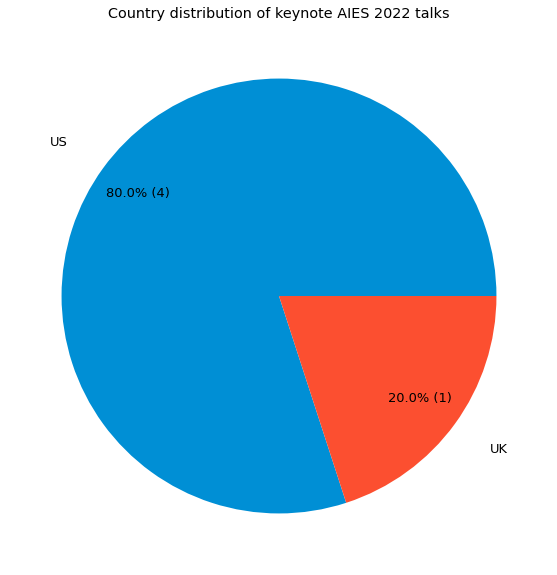

In [11]:
org_hist(keynote_inst, title_pattern='keynote')
plt.savefig("figs/keynote_orgs.png", bbox_inches='tight')
country_pie(keynote_inst, False, title_pattern='keynote')
plt.savefig("figs/keynote_countries.png", bbox_inches='tight')

In [12]:
mon_n = len(mon_inst)
tues_n = len(tues_inst)
student_n = len(student_inst)
keynote_n = len(keynote_inst)
mon_n + tues_n + student_n

120

### Country representation maps

/Users/anitavero/opt/anaconda3/envs/unitary_detoxify/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/anitavero/opt/anaconda3/envs/unitary_detoxify/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/anitavero/opt/anaconda3/envs/unitary_detoxify/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


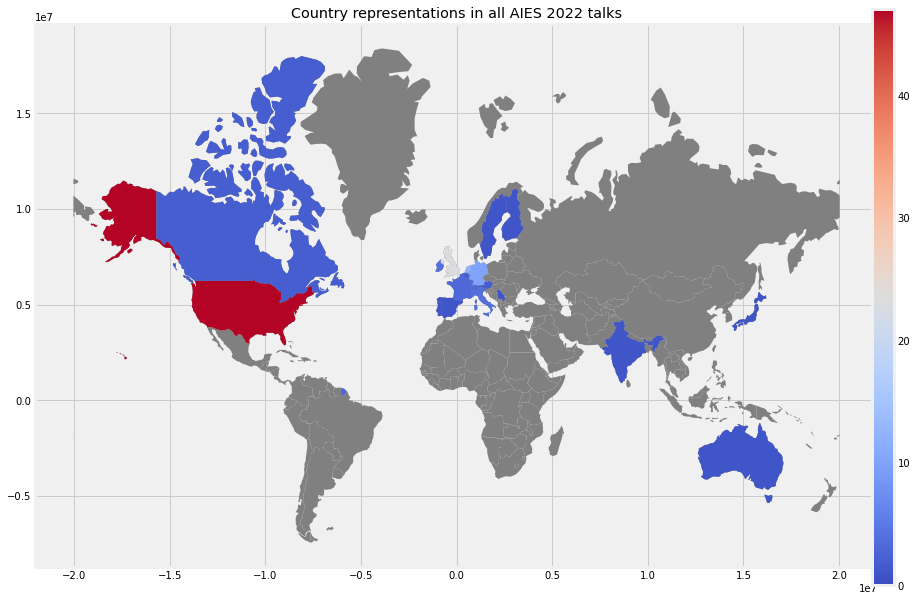

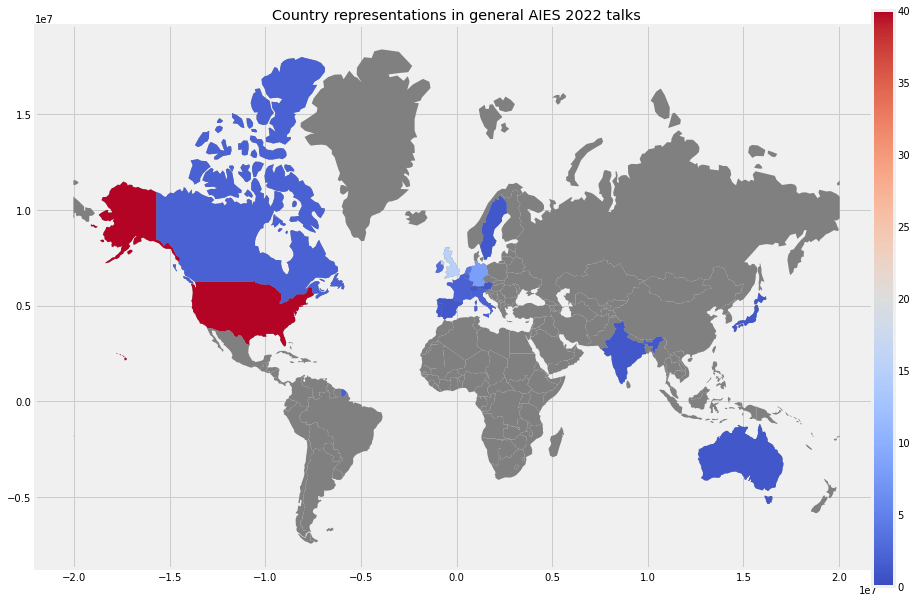

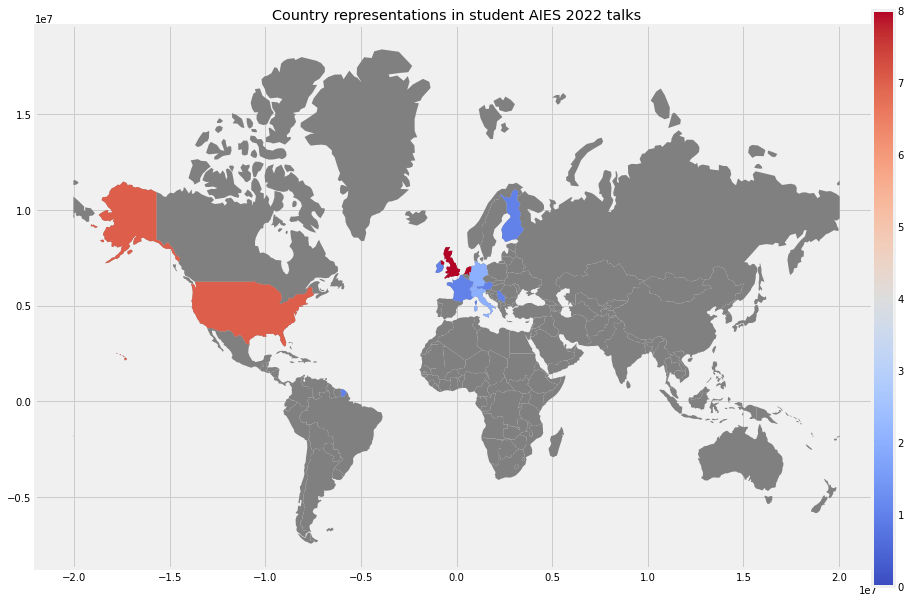

In [68]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize


def plot_map(org_list, title_pattern='all'):
    countries = org_countries(org_list)
    countries = sorted(countries.items(), key=lambda item: item[1], reverse=True)
    vmax = countries[0][1]
    vmin = 0
    cmap = cm.coolwarm
    norm = Normalize(vmin=vmin, vmax=vmax)

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
    world = world.to_crs("EPSG:3395")
    world.plot(color="grey", ax=ax)
    for country, cnt in countries:
        if country in ['US', 'UK']:
            country = {'US': 'United States of America', 'UK': 'United Kingdom'}[country]
        color = cmap(norm(cnt))
        world[world.name == country].plot(color=color, ax=ax)
    plt.title(f'Country representations in {title_pattern} AIES 2022 talks')

    cax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)
        

plot_map(all_talks)
plt.savefig("figs/all_countries_map.png", bbox_inches='tight')
plot_map(mon_inst + tues_inst + keynote_inst, title_pattern='general')
plt.savefig("figs/regular_countries_map.png", bbox_inches='tight')
plot_map(student_inst, title_pattern='student')
plt.savefig("figs/student_countries_map.png", bbox_inches='tight')

### Company / University participation

In [17]:
with open('org_country.json', 'r') as f:
    org_country_dict = json.load(f)
companies = [t for t in all_talks if t in org_country_dict['Company']]
print(len(all_talks))
print(len(companies))

125
6
